In [1]:
import pandas as pd
import numpy as np

from sklearn.neighbors import NearestNeighbors

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.utils import resample
import matplotlib.gridspec as gridspec



# 1 Loading the Data, Preprocessing, Initial Data Analysis

In [205]:
df = pd.read_csv(r"https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv")
df = df.drop(columns=["Channel", "Region"])
df_og = df.copy()
df

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185
...,...,...,...,...,...,...
435,29703,12051,16027,13135,182,2204
436,39228,1431,764,4510,93,2346
437,14531,15488,30243,437,14841,1867
438,10290,1981,2232,1038,168,2125


In [206]:
df = np.log(df + 1)
df_overview = df.copy()

# 2 Detecting Anomalies
## Bootstrap/Robustness estimate & choosing bandwidth
## Hard-Min Score

In [4]:
N_BOOTSTRAP = 100

n_neighbors = np.arange(2, len(df) // 2, 2)
n_neighbors_overview = pd.DataFrame(columns=["score_discrimination_var", "model_var"])

for n_neigh in n_neighbors:
    spread = {i: np.full(N_BOOTSTRAP, np.nan) for i in range(len(df))}
    for i in range(N_BOOTSTRAP):

        sample = resample(df, n_samples=len(df) // 2, replace=False)

        nbrs = NearestNeighbors(n_neighbors=n_neigh, algorithm="ball_tree").fit(sample.to_numpy())
        distances, indices = nbrs.kneighbors(sample.to_numpy())
        distances = np.power(distances, 2) #SQUARE

        sm = np.mean(distances[:, 1:], 1)

        for j, idx in enumerate(sample.index):
            spread[idx][i] = sm[j]

        #res += [np.var(list(map(np.mean, spread.values())))]
    spread_df = pd.DataFrame(spread) # 100 x 400

    n_neighbors_overview.loc[n_neigh, "score_discrimination_var"] = np.var(spread_df.mean()) # discriminatory power :
    # variance over n_neigh for all items (mean over bootstraps for each item) BETWEEN INSTANCE
    n_neighbors_overview.loc[n_neigh, "model_var"] = np.mean(np.var(spread_df))
    # mean over n_neigh for all items (variance over bootstraps for each item = spread of anomaly scores for each instance) WITHIN instance


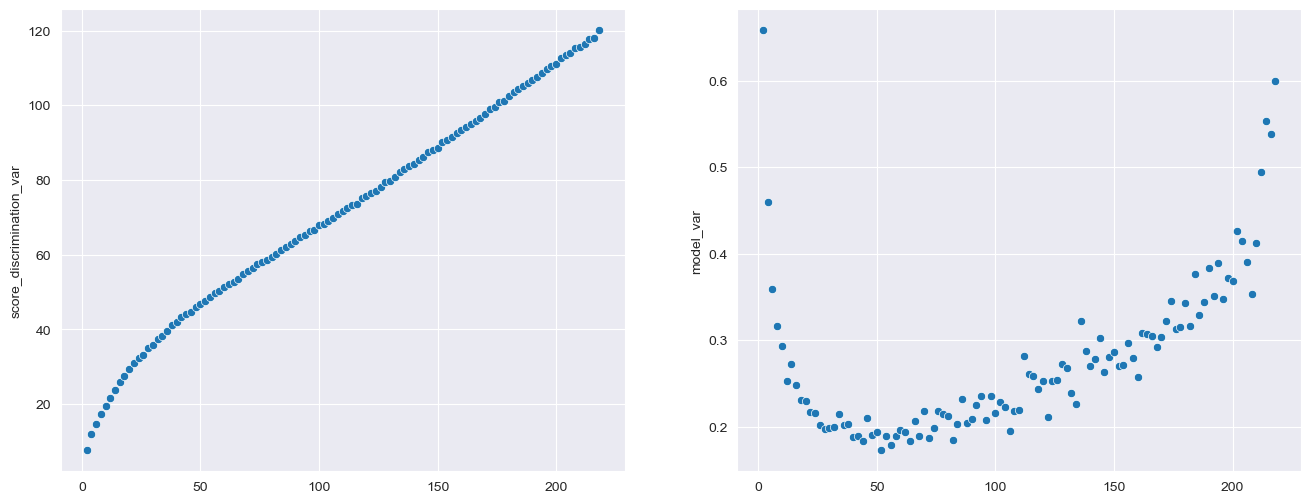

In [5]:
fig = plt.figure(figsize=(16,6))
gs = gridspec.GridSpec(1,2)
ax = {}

ax[1] = fig.add_subplot(gs[0])
ax[0] = sns.scatterplot(x=n_neighbors_overview.index, y=n_neighbors_overview["score_discrimination_var"]) #BETWEEN instance variance for each n_neigh

ax[1] = fig.add_subplot(gs[1])
ax[1] = sns.scatterplot(x=n_neighbors_overview.index, y=n_neighbors_overview["model_var"]) # WITHIN instance variance for each n_neigh
plt.show()

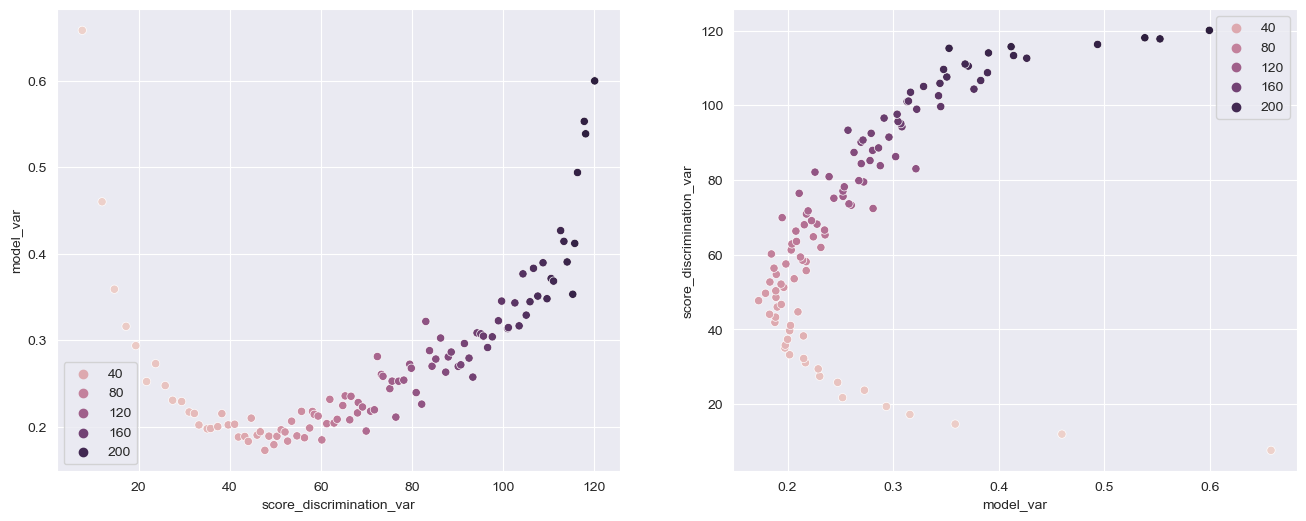

In [7]:
fig = plt.figure(figsize=(16,6))
gs = gridspec.GridSpec(1,2)
ax = {}

ax[1] = fig.add_subplot(gs[0])
ax[0] = sns.scatterplot(x=n_neighbors_overview["score_discrimination_var"], y=n_neighbors_overview["model_var"], hue=n_neighbors)

ax[1] = fig.add_subplot(gs[1])
ax[1] = sns.scatterplot(x=n_neighbors_overview["model_var"], y=n_neighbors_overview["score_discrimination_var"], hue = n_neighbors)
plt.show()

## Soft-Min Score/KDE approach

In [25]:
def softmin(z, gamma):
    return -1 / gamma * np.log(1 / (len(z) - 1) * np.sum(np.exp(-gamma * z)))

In [8]:
g = np.linspace(0.1, 2, 100)
gamma_overview = pd.DataFrame(columns=["score_discrimination_var", "model_var"])

for gamma in g:
    spread = {i: np.full(N_BOOTSTRAP, np.nan) for i in range(len(df))}
    for i in range(N_BOOTSTRAP):

        sample = resample(df, n_samples=len(df) // 2, replace=False)

        nbrs = NearestNeighbors(n_neighbors=len(sample), algorithm="ball_tree").fit(sample.to_numpy())
        distances, indices = nbrs.kneighbors(sample.to_numpy())
        distances = np.power(distances, 2) #SQUARE

        sm = np.apply_along_axis(softmin, 1, distances[:, 1:], gamma)

        for j, idx in enumerate(sample.index):
            spread[idx][i] = sm[j]

        #res += [np.var(list(map(np.mean, spread.values())))]
    spread_df = pd.DataFrame(spread) # 100 x 400

    gamma_overview.loc[gamma, "score_discrimination_var"] = np.var(spread_df.mean()) # discriminatory power :
    # variance over gamma for all items (mean over bootstraps for each item) BETWEEN INSTANCE
    gamma_overview.loc[gamma, "model_var"] = np.mean(np.var(spread_df))
    # mean over gamma for all items (variance over bootstraps for each item = spread of anomaly scores for each instance) WITHIN instance

#res
# sns.histplot(list(map(np.std, spread.values())))

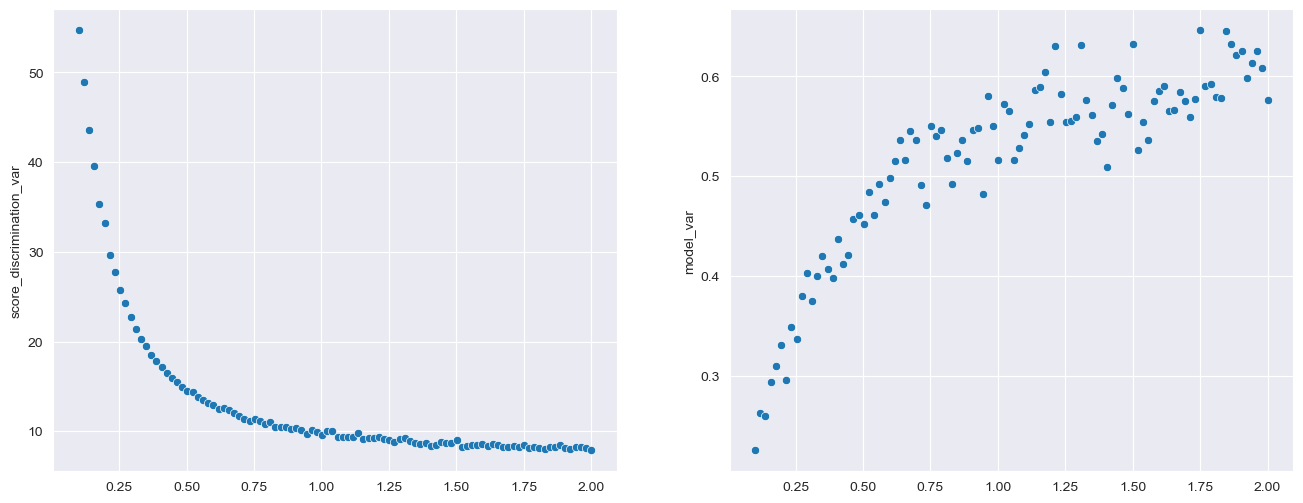

In [9]:
fig = plt.figure(figsize=(16,6))
gs = gridspec.GridSpec(1,2)
ax = {}

ax[1] = fig.add_subplot(gs[0])
ax[0] = sns.scatterplot(x=gamma_overview.index, y=gamma_overview["score_discrimination_var"]) #BETWEEN instance variance for each gamma

ax[1] = fig.add_subplot(gs[1])
ax[1] = sns.scatterplot(x=gamma_overview.index, y=gamma_overview["model_var"]) # WITHIN instance variance for each gamma
plt.show()

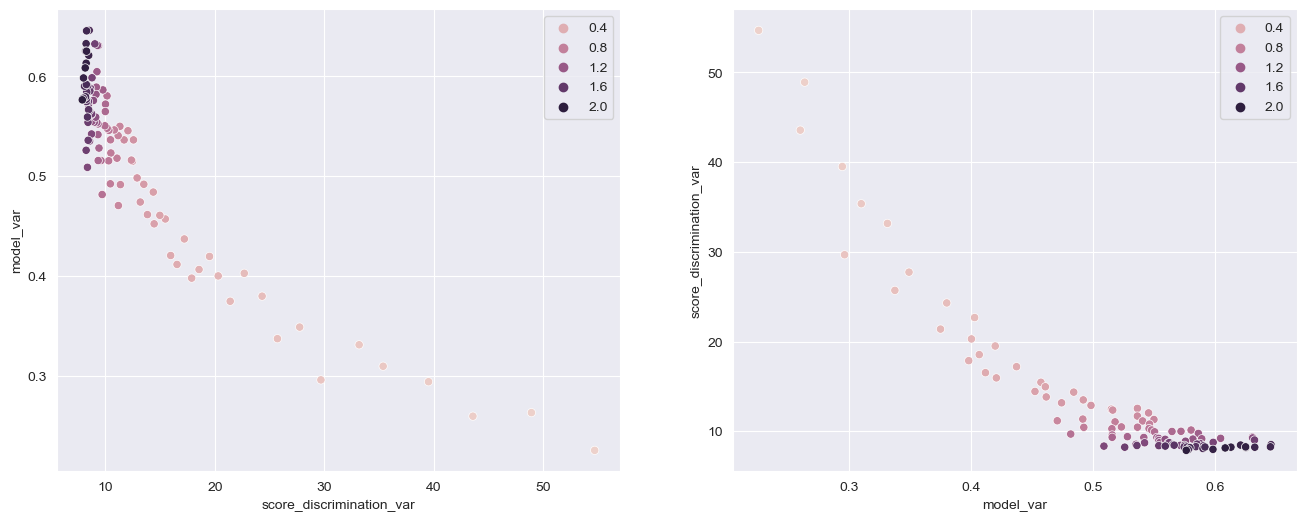

In [10]:
fig = plt.figure(figsize=(16,6))
gs = gridspec.GridSpec(1,2)
ax = {}

ax[1] = fig.add_subplot(gs[0])
ax[0] = sns.scatterplot(x=gamma_overview["score_discrimination_var"], y=gamma_overview["model_var"], hue=g)

ax[1] = fig.add_subplot(gs[1])
ax[1] = sns.scatterplot(x=gamma_overview["model_var"], y=gamma_overview["score_discrimination_var"], hue = g)
plt.show()